In [5]:
from pathlib import Path
from PIL import Image
from collections import Counter
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [6]:
# Convert all images in a folder to RGB format (3 channels)
def convert_to_rgb(folder_path):
    folder = Path(folder_path)
    image_paths = list(folder.rglob("*.*"))

    print(f"Converting {len(image_paths)} images in {folder_path} to RGB...")

    for path in tqdm(image_paths):
        try:
            img = Image.open(path)
            rgb_img = img.convert('RGB')
            rgb_img.save(path)  # overwrite original
        except Exception as e:
            print(f"Failed to process {path}: {e}")

# Convert train and test sets
convert_to_rgb('./data/train')
convert_to_rgb('./data/test')

Converting 33559 images in ./data/train to RGB...


  2%|▏         | 707/33559 [00:01<00:42, 777.06it/s]

Failed to process data/train/.DS_Store: cannot identify image file 'data/train/.DS_Store'


100%|██████████| 33559/33559 [00:10<00:00, 3114.78it/s]


Converting 7179 images in ./data/test to RGB...


  5%|▍         | 347/7179 [00:00<00:01, 3467.12it/s]

Failed to process data/test/.DS_Store: cannot identify image file 'data/test/.DS_Store'


100%|██████████| 7179/7179 [00:01<00:00, 3929.52it/s]


In [7]:
# Make sure all images have the same number of channels
def count_image_channels(directory):
    channel_counts = Counter()
    
    for img_path in Path(directory).rglob("*.*"):  # All files in all subfolders
        try:
            with Image.open(img_path) as img:
                mode = img.mode  # e.g., 'L', 'RGB', 'RGBA'
                if mode == 'L':
                    channels = 1
                elif mode == 'RGB':
                    channels = 3
                elif mode == 'RGBA':
                    channels = 4
                else:
                    channels = '?'
                channel_counts[channels] += 1
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
    
    return channel_counts

# Run on your train and test sets
train_channels = count_image_channels('./data/train')
test_channels = count_image_channels('./data/test')

print("Train set channel distribution:", train_channels)
print("Test set channel distribution:", test_channels)

Error loading data/train/.DS_Store: cannot identify image file 'data/train/.DS_Store'
Error loading data/test/.DS_Store: cannot identify image file 'data/test/.DS_Store'
Train set channel distribution: Counter({3: 33558})
Test set channel distribution: Counter({3: 7178})


In [8]:
disgust_path = './data/train/disgust'
current_count = len(os.listdir(disgust_path))
target_count = 4500
to_generate = target_count - current_count

print(f"Disgust images currently: {current_count}, need to generate: {to_generate}")

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

disgust_images = os.listdir(disgust_path)
generated = 0

print("Generating augmented images...")
while generated < to_generate:
    for img_name in tqdm(disgust_images):
        if generated >= to_generate:
            break

        img_path = os.path.join(disgust_path, img_name)
        try:
            img = load_img(img_path, color_mode='rgb')
            x = img_to_array(img)
            x = x.reshape((1,) + x.shape)

            # Save augmented images in the same directory
            for batch in datagen.flow(x, batch_size=1,
                                      save_to_dir=disgust_path,
                                      save_prefix='aug',
                                      save_format='png'):
                generated += 1
                break  # Only 1 new image per original image
        except Exception as e:
            print(f"Failed to load {img_path}: {e}")

Disgust images currently: 4451, need to generate: 49
Generating augmented images...


  1%|          | 49/4451 [00:00<00:06, 663.05it/s]


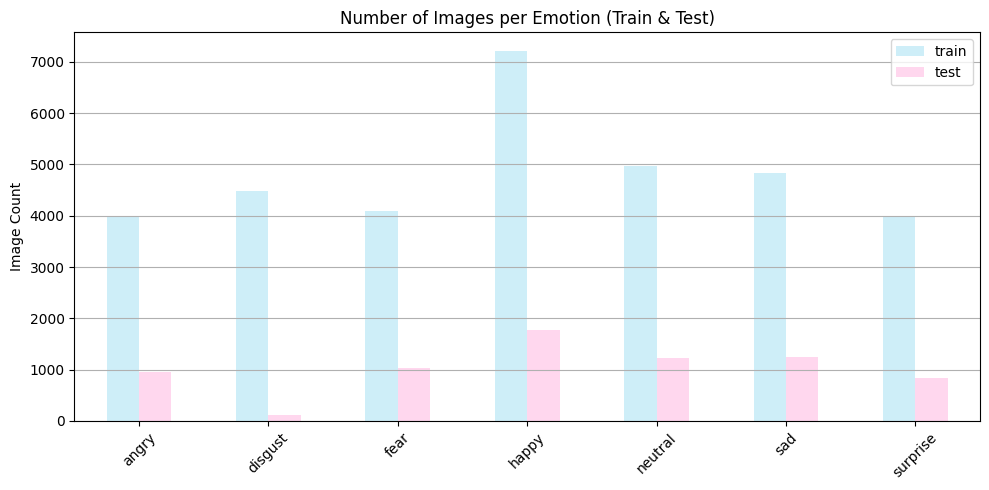

,train,test
angry,4000,958
disgust,4488,111
fear,4097,1024
happy,7215,1774
neutral,4965,1233
sad,4830,1247
surprise,4000,831


In [9]:
# Ensure results directory exists
os.makedirs('./results', exist_ok=True)

# Paths to your dataset
train_path = Path('./data/train')
test_path = Path('./data/test')

# Function to count images in each class folder
def count_images_per_class(base_path):
    class_counts = {}
    for class_dir in base_path.iterdir():
        if class_dir.is_dir():
            class_name = class_dir.name
            count = len(list(class_dir.glob('*')))
            class_counts[class_name] = count
    return class_counts

# Get counts
train_counts = count_images_per_class(train_path)
test_counts = count_images_per_class(test_path)

# Convert to DataFrames
df_train = pd.DataFrame.from_dict(train_counts, orient='index', columns=['train'])
df_test = pd.DataFrame.from_dict(test_counts, orient='index', columns=['test'])
df_all = pd.concat([df_train, df_test], axis=1).fillna(0).astype(int)
df_all = df_all.sort_index()

# Plot with pastel colors
pastel_colors = ['#ceeef8', '#ffd7ee']  # pastel blue for train, pastel orange for test
ax = df_all.plot(kind='bar', figsize=(10, 5), rot=45, color=pastel_colors)

plt.title("Number of Images per Emotion (Train & Test)")
plt.ylabel("Image Count")
plt.grid(axis='y')
plt.tight_layout()

# Save plot to file
plt.savefig('./results/after_data_augmentation_class_distribution.png', dpi=300)
plt.show()

# Optional: display exact counts
display(df_all)

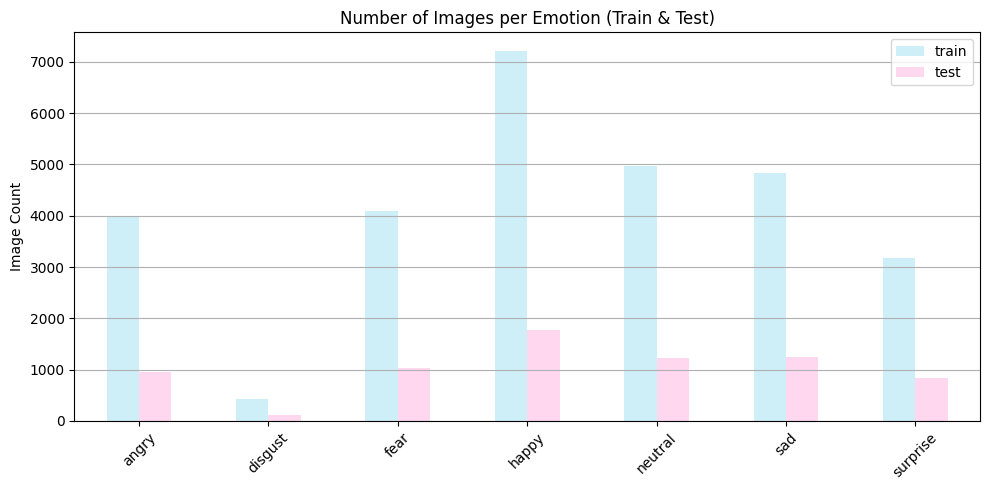

,train,test
angry,3995,958
disgust,436,111
fear,4097,1024
happy,7215,1774
neutral,4965,1233
sad,4830,1247
surprise,3171,831


In [10]:
# Ensure results directory exists
os.makedirs('./results', exist_ok=True)

# Paths to your dataset
train_path = Path('./old_data/train')
test_path = Path('./old_data/test')

# Get counts
train_counts = count_images_per_class(train_path)
test_counts = count_images_per_class(test_path)

# Convert to DataFrames
df_train = pd.DataFrame.from_dict(train_counts, orient='index', columns=['train'])
df_test = pd.DataFrame.from_dict(test_counts, orient='index', columns=['test'])
df_all = pd.concat([df_train, df_test], axis=1).fillna(0).astype(int)
df_all = df_all.sort_index()

# Plot with pastel colors
pastel_colors = ['#ceeef8', '#ffd7ee']  # pastel blue for train, pastel orange for test
ax = df_all.plot(kind='bar', figsize=(10, 5), rot=45, color=pastel_colors)

plt.title("Number of Images per Emotion (Train & Test)")
plt.ylabel("Image Count")
plt.grid(axis='y')
plt.tight_layout()

# Save plot to file
plt.savefig('./results/before_data_augmentation_class_distribution.png', dpi=300)
plt.show()

# Optional: display exact counts
display(df_all)

Min pixel: 0.0
Max pixel: 255.0
Mean: 125.18, Std: 69.54


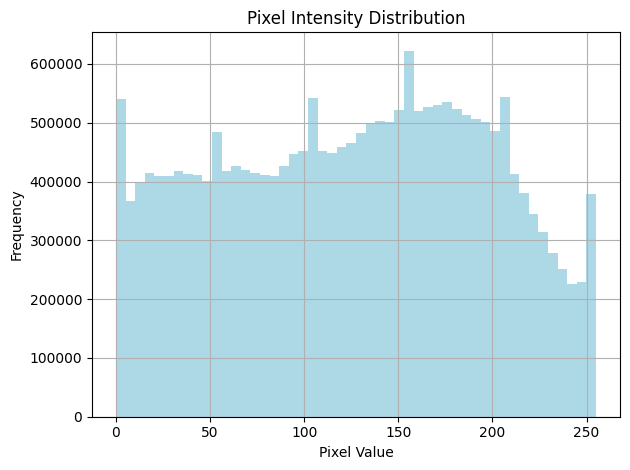

In [11]:
# Random sample of images to test
sample_paths = random.sample(list(Path('./data/train').rglob('*.png')), 1000)

pixel_values = []

for path in sample_paths:
    img = Image.open(path).convert('RGB')  # ensure consistency
    img_array = np.array(img).astype(np.float32)
    pixel_values.extend(img_array.flatten())

pixel_values = np.array(pixel_values)

# Summary stats
print(f"Min pixel: {pixel_values.min()}")
print(f"Max pixel: {pixel_values.max()}")
print(f"Mean: {pixel_values.mean():.2f}, Std: {pixel_values.std():.2f}")

# Plot histogram
plt.hist(pixel_values, bins=50, color='lightblue')
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()

# Save to file
plt.savefig('./results/pixel_distribution_before_normalization.png', dpi=300)
plt.show()

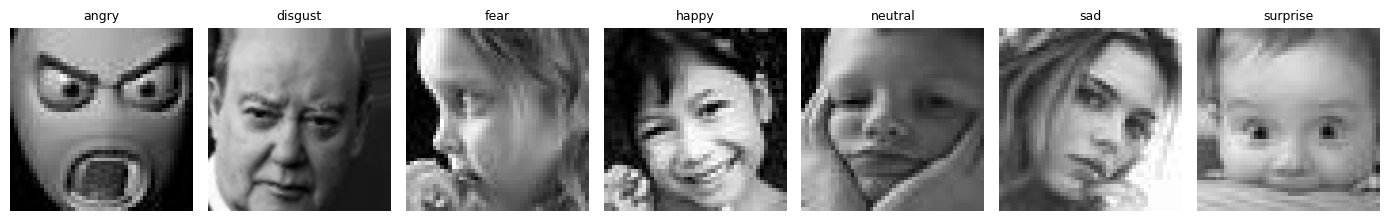

Saved to ./results/emotion_examples.png


In [12]:
# Define paths and class names
base_dir = Path('./data/train')
class_names = sorted([p.name for p in base_dir.iterdir() if p.is_dir()])
output_path = './results/emotion_examples.png'

# Ensure results folder exists
os.makedirs('./results', exist_ok=True)

# Set figure size based on number of classes
fig, axes = plt.subplots(1, len(class_names), figsize=(len(class_names) * 2, 2.5))

# Plot one image per class
for i, class_name in enumerate(class_names):
    class_path = base_dir / class_name
    image_paths = list(class_path.glob('*'))
    chosen_path = random.choice(image_paths)

    img = Image.open(chosen_path)
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(class_name, fontsize=9)

plt.tight_layout()
plt.savefig(output_path, dpi=300)
plt.show()

print(f"Saved to {output_path}")

Running PCA...
Running t-SNE...


/Users/yuyi/Desktop/DeepLearningProject/venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


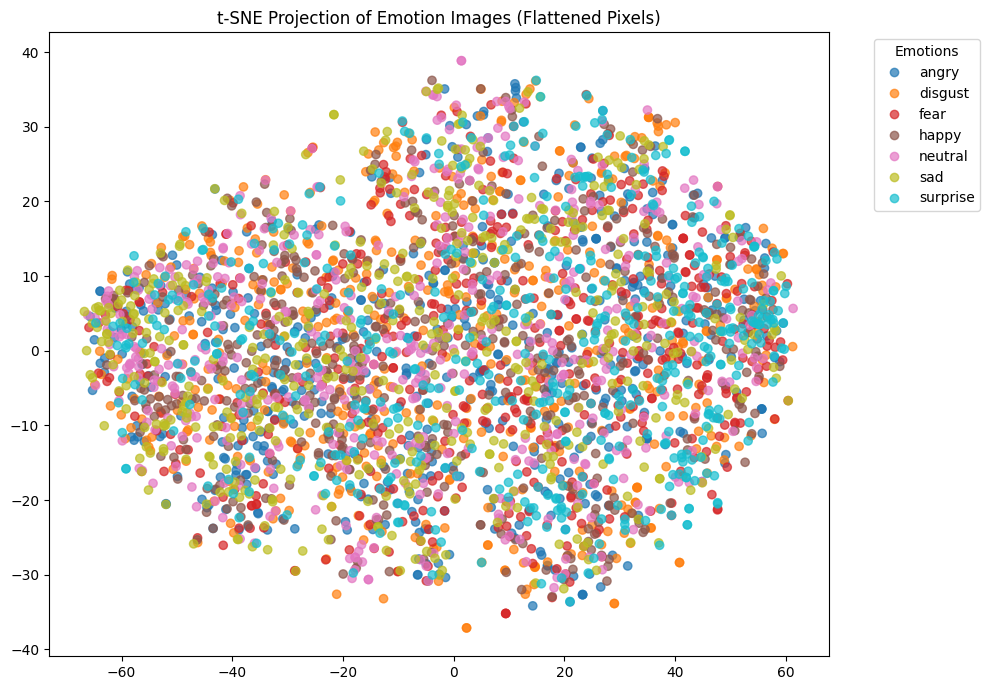

In [15]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from pathlib import Path
import random
import os

# Settings
base_dir = Path('./data/train')
class_names = sorted([p.name for p in base_dir.iterdir() if p.is_dir()])
samples_per_class = 500  # total ~7x500 = 3500

# Collect data and labels
images = []
labels = []

for idx, class_name in enumerate(class_names):
    class_path = base_dir / class_name
    image_paths = list(class_path.glob('*'))
    selected_paths = random.sample(image_paths, min(samples_per_class, len(image_paths)))

    for path in selected_paths:
        img = Image.open(path).convert('L').resize((48, 48))  # grayscale, consistent size
        img_array = np.array(img).flatten()  # shape: (48*48,)
        images.append(img_array)
        labels.append(idx)

images = np.array(images)
labels = np.array(labels)

# Optional: reduce dimensionality before t-SNE (recommended)
print("Running PCA...")
pca = PCA(n_components=50)
images_pca = pca.fit_transform(images)

# Run t-SNE
print("Running t-SNE...")
tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
images_tsne = tsne.fit_transform(images_pca)

# Plot
plt.figure(figsize=(10, 7))
scatter = plt.scatter(images_tsne[:, 0], images_tsne[:, 1], c=labels, cmap='tab10', alpha=0.7)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names, title="Emotions", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("t-SNE Projection of Emotion Images (Flattened Pixels)")
plt.tight_layout()
os.makedirs('./results', exist_ok=True)
plt.savefig('./results/tsne_emotions_before_training.png', dpi=300)
plt.show()